In [99]:
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [100]:
#Experimental Data
Temp = [1223.15, 1273.15, 1323.15, 1373.15, 1273.15, 1273.15]
Feed = [0.0024, 0.0024, 0.0024, 0.0024, 0.00024, 0.004]
exp = [0.830129146, 0.812426766, 0.785513487, 0.706470438, 0.690689298, 0.82341653]

In [101]:
def run_simulation(x,Tx,Fx):
    # Separate gas and interface multipliers
    gas_mult = 0.501
    interface_mult = x[:]
    # import the model for gas-Fe interface and adjacent gas phase
    cat = ct.Interface('FeSiO2_NOMC.yaml','Fe_surf')
    gas = cat.adjacent['gas']

    # Set gas phase reaction multiplier
    gas.set_multiplier(gas_mult)

    # Set interface reaction multipliers
    for i, mult in enumerate(interface_mult):
        cat.set_multiplier(mult, i)

    T0 = Tx # K
    p0 = ct.one_atm # atm
    gas.TPX = T0, p0, "CH4: 0.9, N2: 0.1"
    cat.TP = T0, p0
    D = 0.004 # diameter of the tube [m]
    Ac = np.pi * D**2 / 4 # cross section of the tube [m2]
    w_cat = 0.84 # weight of catalyst [gcat]
    GHSV = Fx # m3/gcat/hr
    u0 = GHSV * w_cat /3600 / Ac # [m/s]

    # Set the Reactor conditions
    reactor = ct.FlowReactor(gas)
    reactor.area = Ac
    reactor.mass_flow_rate = 0.704672614990904 * u0 * Ac
    reactor.energy_enabled = False
    rsurf = ct.ReactorSurface(cat, reactor)
    net = ct.ReactorNet([reactor])
    soln = ct.SolutionArray(gas, extra=['x', 'surf_coverages'])

    # Integrate the reactor network
    while net.distance < 0.06:
        net.step()
        wdot = rsurf.kinetics.net_production_rates
        soln.append(TDY=reactor.thermo.TDY,
                    x=net.distance,
                    surf_coverages=rsurf.coverages
        )
    return soln('CH4').Y[-1][0]


In [102]:
def objective(x):
    error = 0
    for i in range(len(Temp)):
        try:
            result = run_simulation(x,Temp[i],Feed[i])
            error += (result - exp[i])**2
        except Exception as e:
            error += 1e6
        # result = run_simulation(x,Temp[i],Feed[i])
        # error += (result - exp[i])**2
    return error

In [103]:
# Set the Optimizer
iter = 1000
cost = np.inf
best = 0
for i in range(iter):
    x0 = [10**(-6+12*np.random.random()),10**(-6+12*np.random.random()),10**(-6+12*np.random.random()),10**(-6+12*np.random.random()),10**(-6+12*np.random.random())]
    bounds = []
    for j in range(len(x0)):
        bounds.append((x0[j]*0.1,x0[j]*10))
    res = minimize(objective,x0,method='L-BFGS-B',bounds=bounds)
    if cost > res.fun:
        cost = res.fun
        best = res.x
        print(f'Iter [{i}/1000], fun: {cost}')


KeyboardInterrupt: 

In [ ]:
# Extract optimized multipliers
optimized_multipliers = res.x
print(res.x)
print(res)
# # Run final simulation with optimized multipliers
# try:
#     final_ch4_concentration = objective(optimized_multipliers)
#     print("Optimization completed.")
#     print(f"Optimized gas phase multiplier: {optimized_multipliers[0]}")
#     print("Optimized interface reaction multipliers:")
#     for i, mult in enumerate(optimized_multipliers[1:]):
#         print(f"Reaction {i}: {mult}")
#     print(f"Final CH4 concentration: {final_ch4_concentration}")
# except Exception as e:
#     print(f"Error in final simulation: {e}")
#     print("Optimization may have failed to find a valid solution.")

[5.00000025]
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.009151659674555732
        x: [ 5.000e+00]
      nit: 4
      jac: [ 6.966e+03]
     nfev: 70
     njev: 35
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


iter = 0/201
iter = 10/201
iter = 20/201
iter = 30/201
iter = 40/201
iter = 50/201
iter = 60/201
iter = 70/201
iter = 80/201
iter = 90/201
iter = 100/201
iter = 110/201
iter = 120/201
iter = 130/201
iter = 140/201
iter = 150/201
iter = 160/201
iter = 170/201
iter = 180/201
iter = 190/201
iter = 200/201


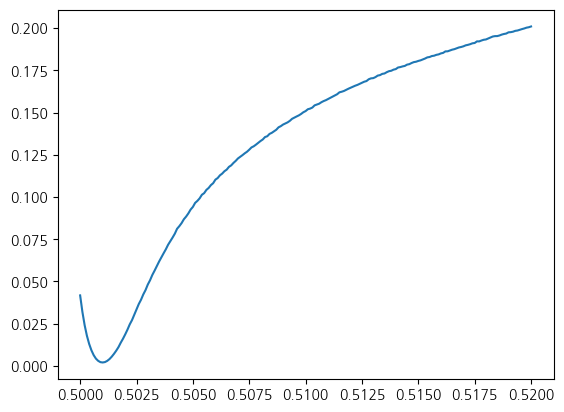

In [ ]:
nn = np.arange(0.50,0.52,0.0001)
ii = np.zeros(len(nn))
for i in range(len(nn)):
    ii[i] = objective([i,1,1,1,1,1])
    if i % 10 == 0:
        print(f'iter = {i}/{len(nn)}')
plt.plot(nn,ii)

In [ ]:
nn[np.argmin(ii)]

0.5009999999999999

In [ ]:
ii[0.501]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices